# Taller 2: Regresión

In [980]:

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor


In [981]:
df = pd.read_csv('data/training_pruebas.csv', header=0)
dfTest = pd.read_csv('data/test_pruebas.csv', header=0)

C:\Users\Migue\AppData\Local\Temp\ipykernel_11252\874024968.py:1: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/training_pruebas.csv', header=0)
C:\Users\Migue\AppData\Local\Temp\ipykernel_11252\874024968.py:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  dfTest = pd.read_csv('data/test_pruebas.csv', header=0)


In [982]:
dfFinal = df['PUNT_GLOBAL']

# Exploración de datos

Despues de realizar una exploración visual de las variables y que significaban cada una se escogieron las siguientes
- ESTU_GENERO
- ESTU_FECHANACIMIENTO -> EDAD
- PERIODO
- ESTU_DEPTO_RESIDE
- ESTU_AREARESIDE
- ESTU_TITULOOBTENIDOBACHILLER
- ESTU_VALORMATRICULAUNIVERSIDAD
- ESTU_PAGOMATRICULA
- ESTU_COMOCAPACITOEXAMENSB11
- ESTU_SEMESTRECURSA
- FAMI_EDUCACIONPADRE
- FAMI_EDUCACIONMADRE
- FAMI_ESTRATOVIVIENDA
- FAMI_TIENEINTERNET
- FAMI_TIENESERVICIOTV
- FAMI_TIENECOMPUTADOR
- FAMI_TIENECONSOLAVIDEOJUEGOS
- ESTU_HORASSEMANATRABAJA
- GRUPOREFERENCIA
- ESTU_PRGM_DEPARTAMENTO
- ESTU_METODO_PRGM
- INST_CARACTER_ACADEMICO

A estas variables se les hara algunas exploraciones y transformaciones segun se requiera. Estas variables no son las escogidas como finales para crear el modelo si no como las escogidas despues de una exploración basica de los datos
___

In [983]:
def calcular_correlacion_dummies(df, columna_categoria, columna_objetivo):
    """
    Calcula la correlación entre las variables dummy creadas a partir de una columna categórica
    y una variable objetivo.

    Parámetros:
    df (DataFrame): El DataFrame que contiene los datos.
    columna_categoria (str): El nombre de la columna categórica para crear las dummies.
    columna_objetivo (str): El nombre de la columna objetivo para calcular la correlación.

    Retorna:
    DataFrame: Un DataFrame con las correlaciones entre las dummies y la variable objetivo.
    """
    df_dummies = pd.get_dummies(df[columna_categoria])
    
    df_con_dummies = pd.concat([df, df_dummies], axis=1)
    
    correlaciones = df_con_dummies[df_dummies.columns].corrwith(df[columna_objetivo])
    
    return correlaciones


In [984]:
def eliminar_tildes(texto):
    """
    Elimina tildes y acentos de un texto.
    
    Parámetros:
    texto (str): El texto a normalizar.
    
    Retorna:
    str: El texto sin tildes ni acentos.
    """
    texto_normalizado = unicodedata.normalize('NFD', texto)
    texto_sin_tildes = ''.join([char for char in texto_normalizado if unicodedata.category(char) != 'Mn'])
    return texto_sin_tildes.lower()

def asignar_region(departamento):
    """
    Asigna una región colombiana o la categoría 'Extranjero' basada en el departamento de residencia.
    
    Parámetros:
    departamento (str): El departamento de residencia.
    
    Retorna:
    str: El nombre de la región o 'Extranjero'.
    """
    regiones = {
        'Andina': ['Antioquia', 'Boyacá', 'Cundinamarca', 'Santander', 'Tolima', 
                   'Quindío', 'Risaralda', 'Caldas', 'Bogotá', 'Norte Santander'],
        'Pacífico': ['Chocó', 'Valle', 'Cauca', 'Nariño'],
        'Caribe': ['Atlántico', 'Bolívar', 'Cesar', 'Córdoba', 'La Guajira', 
                   'Magdalena', 'Sucre', 'San Andres'],
        'Orinoquía': ['Arauca', 'Casanare', 'Meta', 'Vichada'],
        'Amazonía': ['Amazonas', 'Caquetá', 'Guainía', 'Guaviare', 'Putumayo', 'Vaupés'],
        'Insular': ['San Andrés y Providencia']
    }
    
    extranjero = ['LIMA', 'MADRID', 'PARIS', 'CALGARY', 'FLANDES ORIENTAL', 
                  'MIAMI', 'MELBOURNE', 'BERLIN', 'SYDNEY', 'VALENCIA', 'GUADALAJARA', 'NUEVA YORK']
    
    departamento_normalizado = eliminar_tildes(departamento)


    if departamento_normalizado in [eliminar_tildes(loc) for loc in extranjero]:
        return 'Extranjero'
    
    for region, departamentos in regiones.items():
        if departamento_normalizado in [eliminar_tildes(dpto) for dpto in departamentos]:
            return region
    
    return 'Otro'  # Para casos que no coincidan

___

## ESTU_GENERO

F   -0.074096
M    0.074096
dtype: float64


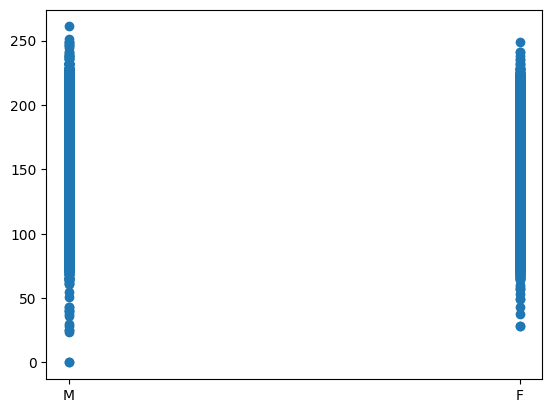

In [985]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_GENERO', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_GENERO'], df['PUNT_GLOBAL'])

dummies = pd.get_dummies(df['ESTU_GENERO'], prefix='GENERO', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [986]:
dummies = pd.get_dummies(dfTest['ESTU_GENERO'], prefix='GENERO', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_FECHANACIMIENTO -> EDAD

             PUNT_GLOBAL      EDAD
PUNT_GLOBAL     1.000000 -0.159565
EDAD           -0.159565  1.000000


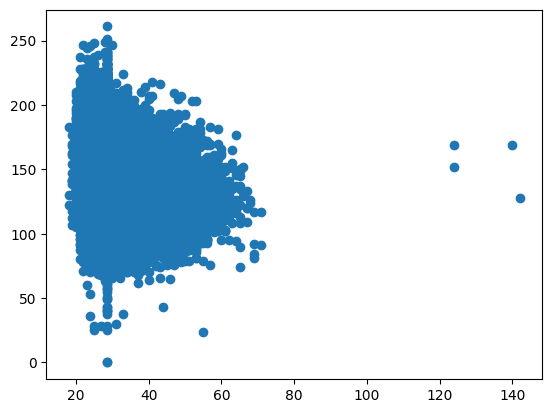

In [987]:
def calcular_edad(df, fecha_nacimiento_col):
    df[fecha_nacimiento_col] = pd.to_datetime(df[fecha_nacimiento_col], errors='coerce')
    fecha_actual = datetime.now()
    df['EDAD'] = df[fecha_nacimiento_col].apply(lambda fecha: fecha_actual.year - fecha.year - ((fecha_actual.month, fecha_actual.day) < (fecha.month, fecha.day)))
    return df

df = calcular_edad(df, 'ESTU_FECHANACIMIENTO')
MEAN = df['EDAD'].mean()
df['EDAD'] = df['EDAD'].fillna(MEAN)

dfFinal = pd.concat([dfFinal, df['EDAD']], axis=1)
print(df[['PUNT_GLOBAL', 'EDAD']].corr())
plt.scatter(df['EDAD'], df['PUNT_GLOBAL'])

In [988]:
dfTest = calcular_edad(dfTest, 'ESTU_FECHANACIMIENTO')
dfTest['EDAD'].isnull().sum()
MEAN = dfTest['EDAD'].mean()
dfTest['EDAD'] = dfTest['EDAD'].fillna(MEAN)

___

## PERIODO

              PERIODO  PUNT_GLOBAL
PERIODO      1.000000     0.081207
PUNT_GLOBAL  0.081207     1.000000


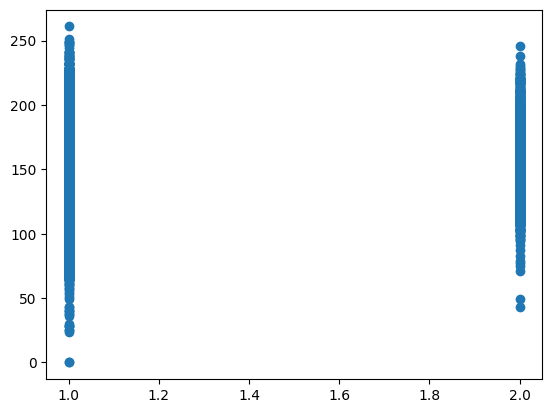

In [989]:
df['PERIODO'] = df['PERIODO'].replace({20231: 1, 20232: 2})
dfFinal = pd.concat([dfFinal, df['PERIODO']], axis=1)
print(df[['PERIODO', 'PUNT_GLOBAL']].corr())
plt.scatter(df['PERIODO'], df['PUNT_GLOBAL'])

In [990]:
dfTest['PERIODO'] = dfTest['PERIODO'].replace({20231: 1, 20232: 2})


___

## ESTU_DEPTO_RESIDE -> REGION_RESIDENCIA

In [991]:
df['REGION_RESIDENCIA'] = df['ESTU_DEPTO_RESIDE'].apply(asignar_region)

Amazonía     -0.057157
Andina        0.177920
Caribe       -0.114300
Extranjero    0.007779
Orinoquía    -0.055322
Otro         -0.034591
Pacífico     -0.063411
dtype: float64


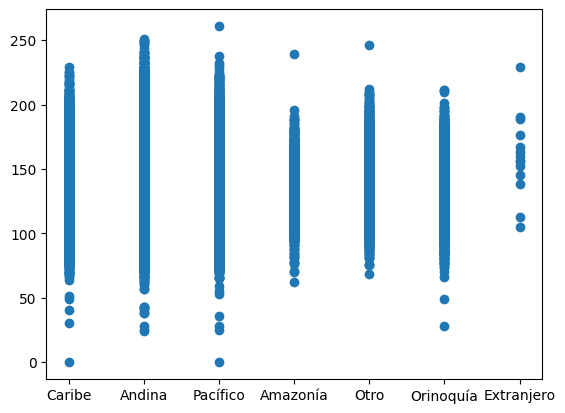

In [992]:
correlaciones = calcular_correlacion_dummies(df, 'REGION_RESIDENCIA', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['REGION_RESIDENCIA'], df['PUNT_GLOBAL'])

dummies = pd.get_dummies(df['REGION_RESIDENCIA'], prefix='REGION_RESIDENCIA', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [993]:
dfTest['REGION_RESIDENCIA'] = dfTest['ESTU_DEPTO_RESIDE'].apply(asignar_region)
dummies = pd.get_dummies(dfTest['REGION_RESIDENCIA'], prefix='REGION_RESIDENCIA', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_AREARESIDE

In [994]:
MODA = df['ESTU_AREARESIDE'].value_counts().idxmax()
df['ESTU_AREARESIDE'] = df['ESTU_AREARESIDE'].fillna(MODA)

Area Rural           -0.129077
Cabecera Municipal    0.129077
dtype: float64


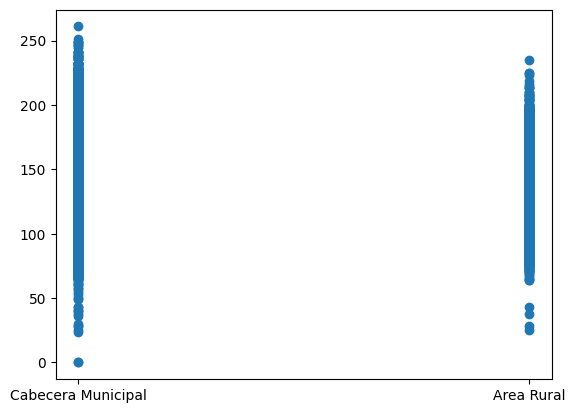

In [995]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_AREARESIDE', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_AREARESIDE'], df['PUNT_GLOBAL'])

dummies = pd.get_dummies(df['ESTU_AREARESIDE'], prefix='AREARESIDE', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [996]:
MODA = dfTest['ESTU_AREARESIDE'].value_counts().idxmax()
dfTest['ESTU_AREARESIDE'] = dfTest['ESTU_AREARESIDE'].fillna(MODA)
dummies = pd.get_dummies(dfTest['ESTU_AREARESIDE'], prefix='AREARESIDE', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_TITULOOBTENIDOBACHILLER

In [997]:
df['ESTU_TITULOOBTENIDOBACHILLER'] = df['ESTU_TITULOOBTENIDOBACHILLER'].replace({
    'Bachiller académico': 'académico',
    'Bachiller técnico': 'técnico',
    'Bachiller pedagógico': 'pedagógico'
})
MODA = df['ESTU_TITULOOBTENIDOBACHILLER'].value_counts().idxmax()
df['ESTU_TITULOOBTENIDOBACHILLER'] = df['ESTU_TITULOOBTENIDOBACHILLER'].fillna(MODA)

Bachiller pedagógico o normalista   -0.004141
académico                            0.025790
técnico                             -0.025083
dtype: float64


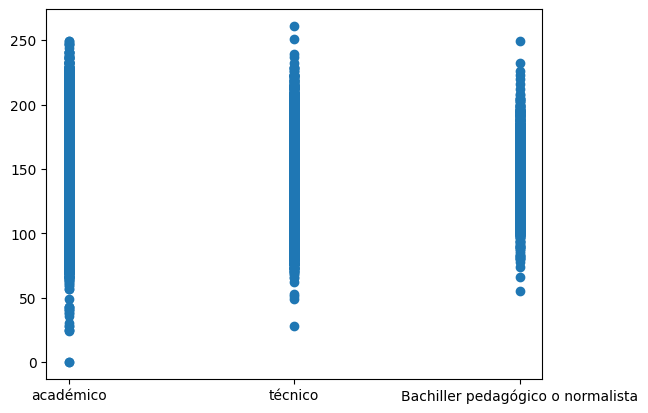

In [998]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_TITULOOBTENIDOBACHILLER', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_TITULOOBTENIDOBACHILLER'], df['PUNT_GLOBAL'])

dummies = pd.get_dummies(df['ESTU_TITULOOBTENIDOBACHILLER'], prefix='TITULOOBTENIDOBACHILLER', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [999]:
dfTest['ESTU_TITULOOBTENIDOBACHILLER'] = dfTest['ESTU_TITULOOBTENIDOBACHILLER'].replace({
    'Bachiller académico': 'académico',
    'Bachiller técnico': 'técnico',
    'Bachiller pedagógico': 'pedagógico'
})
MODA = dfTest['ESTU_TITULOOBTENIDOBACHILLER'].value_counts().idxmax()
dfTest['ESTU_TITULOOBTENIDOBACHILLER'] = dfTest['ESTU_TITULOOBTENIDOBACHILLER'].fillna(MODA)

dummies = pd.get_dummies(dfTest['ESTU_TITULOOBTENIDOBACHILLER'], prefix='TITULOOBTENIDOBACHILLER', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_VALORMATRICULAUNIVERSIDAD

In [1000]:
MODA = df['ESTU_VALORMATRICULAUNIVERSIDAD'].value_counts().idxmax()
df['ESTU_VALORMATRICULAUNIVERSIDAD'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna(MODA)

df['ESTU_VALORMATRICULAUNIVERSIDAD'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace({
    'No pagó matrícula': 'MUY BAJO',
    'Menos de 500 mil': 'MUY BAJO', 
    'Entre 500 mil y menos de 1 millón': 'BAJO',
    'Entre 1 millón y menos de 2.5 millones': 'MEDIO',
    'Entre 2.5 millones y menos de 4 millones': 'MEDIO',
    'Entre 4 millones y menos de 5.5 millones': 'ALTO',
    'Entre 5.5 millones y menos de 7 millones': 'ALTO',
    'Más de 7 millones': 'MUY ALTO'
})

ALTO        0.048047
BAJO        0.008578
MEDIO      -0.198636
MUY ALTO    0.244534
MUY BAJO    0.030722
dtype: float64


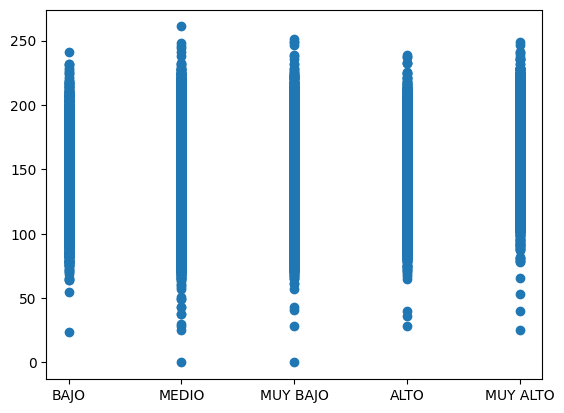

In [1001]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_VALORMATRICULAUNIVERSIDAD', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_VALORMATRICULAUNIVERSIDAD'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['ESTU_VALORMATRICULAUNIVERSIDAD'], prefix='VALORMATRICULA',drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [1002]:
MODA = dfTest['ESTU_VALORMATRICULAUNIVERSIDAD'].value_counts().idxmax()
dfTest['ESTU_VALORMATRICULAUNIVERSIDAD'] = dfTest['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna(MODA)

dfTest['ESTU_VALORMATRICULAUNIVERSIDAD'] = dfTest['ESTU_VALORMATRICULAUNIVERSIDAD'].replace({
    'No pagó matrícula': 'MUY BAJO',
    'Menos de 500 mil': 'MUY BAJO', 
    'Entre 500 mil y menos de 1 millón': 'BAJO',
    'Entre 1 millón y menos de 2.5 millones': 'MEDIO',
    'Entre 2.5 millones y menos de 4 millones': 'MEDIO',
    'Entre 4 millones y menos de 5.5 millones': 'ALTO',
    'Entre 5.5 millones y menos de 7 millones': 'ALTO',
    'Más de 7 millones': 'MUY ALTO'
})

dummies = pd.get_dummies(dfTest['ESTU_VALORMATRICULAUNIVERSIDAD'], prefix='VALORMATRICULA',drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_PAGOMATRICULA

In [1003]:
MODA = df['ESTU_PAGOMATRICULA'].value_counts().idxmax()
df['ESTU_PAGOMATRICULA'] = df['ESTU_PAGOMATRICULA'].fillna(MODA)

 Propios            -0.071087
Becas o Subsidios    0.065554
Creditos            -0.107903
Familiares           0.107739
dtype: float64


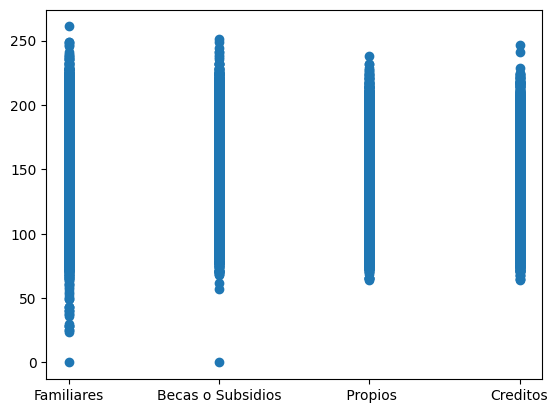

In [1004]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_PAGOMATRICULA', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_PAGOMATRICULA'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['ESTU_PAGOMATRICULA'], prefix='PAGOMATRICULA', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [1005]:
MODA = dfTest['ESTU_PAGOMATRICULA'].value_counts().idxmax()
dfTest['ESTU_PAGOMATRICULA'] = dfTest['ESTU_PAGOMATRICULA'].fillna(MODA)

dummies = pd.get_dummies(dfTest['ESTU_PAGOMATRICULA'], prefix='PAGOMATRICULA', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_COMOCAPACITOEXAMENSB11

In [1006]:
MODA = df['ESTU_COMOCAPACITOEXAMENSB11'].value_counts().idxmax()
df['ESTU_COMOCAPACITOEXAMENSB11'] = df['ESTU_COMOCAPACITOEXAMENSB11'].fillna(MODA)

No realizó ninguna prueba de preparación    0.091734
Repasó por cuenta propia                   -0.083364
Tomó un curso de preparación               -0.002553
dtype: float64


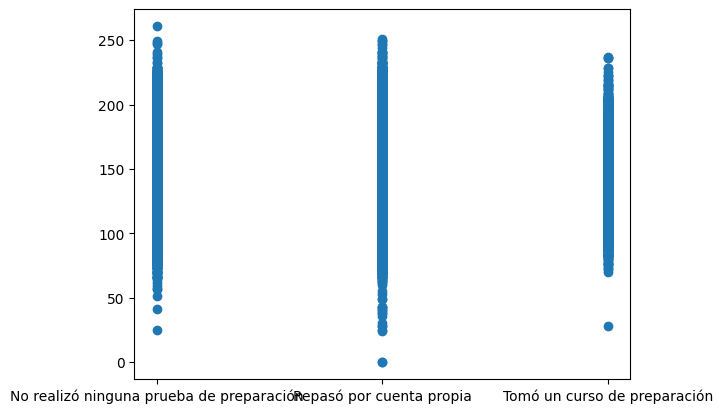

In [1007]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_COMOCAPACITOEXAMENSB11', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_COMOCAPACITOEXAMENSB11'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['ESTU_COMOCAPACITOEXAMENSB11'], prefix='COMOCAPACITOEXAMENSB11', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [1008]:
MODA = dfTest['ESTU_COMOCAPACITOEXAMENSB11'].value_counts().idxmax()
dfTest['ESTU_COMOCAPACITOEXAMENSB11'] = dfTest['ESTU_COMOCAPACITOEXAMENSB11'].fillna(MODA)

dummies = pd.get_dummies(dfTest['ESTU_COMOCAPACITOEXAMENSB11'], prefix='COMOCAPACITOEXAMENSB11', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_SEMESTRECURSA

In [1009]:
MODA = df['ESTU_SEMESTRECURSA'].value_counts().idxmax()
df['ESTU_SEMESTRECURSA'] = df['ESTU_SEMESTRECURSA'].fillna(MODA)
df['ESTU_SEMESTRECURSA'] = df['ESTU_SEMESTRECURSA'].replace('12 o más', 12)
df['ESTU_SEMESTRECURSA'] = df['ESTU_SEMESTRECURSA'].astype(int)

                    ESTU_SEMESTRECURSA  PUNT_GLOBAL
ESTU_SEMESTRECURSA            1.000000     0.084303
PUNT_GLOBAL                   0.084303     1.000000


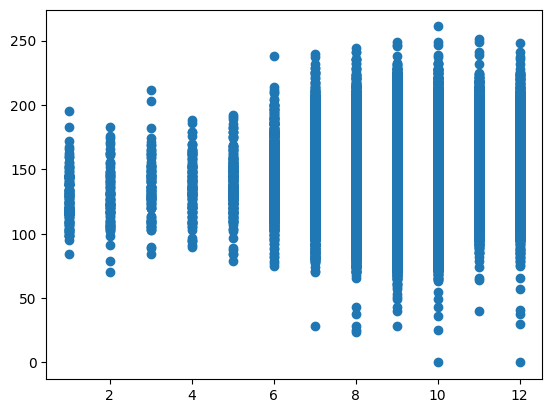

In [1010]:
dfFinal = pd.concat([dfFinal, df['ESTU_SEMESTRECURSA']], axis=1)
print(df[['ESTU_SEMESTRECURSA', 'PUNT_GLOBAL']].corr())
plt.scatter(df['ESTU_SEMESTRECURSA'], df['PUNT_GLOBAL'])

In [1011]:
MODA = dfTest['ESTU_SEMESTRECURSA'].value_counts().idxmax()
dfTest['ESTU_SEMESTRECURSA'] = dfTest['ESTU_SEMESTRECURSA'].fillna(MODA)
dfTest['ESTU_SEMESTRECURSA'] = dfTest['ESTU_SEMESTRECURSA'].replace('12 o más', 12)
dfTest['ESTU_SEMESTRECURSA'] = dfTest['ESTU_SEMESTRECURSA'].astype(int)

___

## FAMI_EDUCACIONPADRE

In [1012]:
MODA = df['FAMI_EDUCACIONPADRE'].value_counts().idxmax()
df['FAMI_EDUCACIONPADRE'] = df['FAMI_EDUCACIONPADRE'].fillna(MODA)

In [1013]:
df['FAMI_EDUCACIONPADRE'] = df['FAMI_EDUCACIONPADRE'].replace({
    'Educación profesional completa': 'PROFESIONAL',
    'Educación profesional incompleta': 'PROFESIONAL', 
    'Postgrado': 'PROFESIONAL',
    'Técnica o tecnológica completa': 'MEDIA',
    'Técnica o tecnológica incompleta': 'MEDIA',
    'Primaria completa': 'BASICA',
    'Primaria incompleta': 'BASICA',
    'Secundaria (Bachillerato) completa': 'BASICA',
    'Secundaria (Bachillerato) incompleta': 'BASICA',
    'Ninguno': 'NINGUNO',
    'No Aplica': 'NINGUNO',
    'No sabe': 'NINGUNO'
})

BASICA        -0.161566
MEDIA          0.037558
NINGUNO       -0.069561
PROFESIONAL    0.214953
dtype: float64


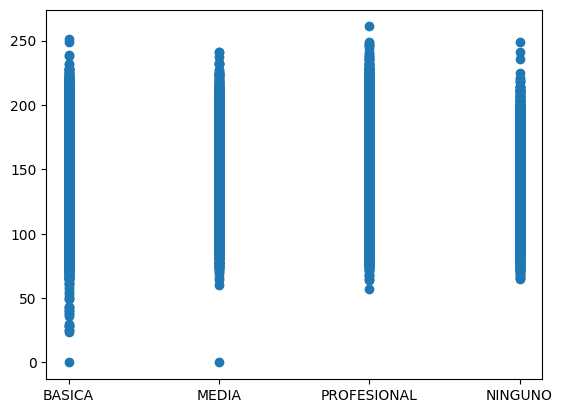

In [1014]:
correlaciones = calcular_correlacion_dummies(df, 'FAMI_EDUCACIONPADRE', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['FAMI_EDUCACIONPADRE'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['FAMI_EDUCACIONPADRE'], prefix='EDUCACIONPADRE', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [1015]:
MODA = dfTest['FAMI_EDUCACIONPADRE'].value_counts().idxmax()
dfTest['FAMI_EDUCACIONPADRE'] = dfTest['FAMI_EDUCACIONPADRE'].fillna(MODA)
dfTest['FAMI_EDUCACIONPADRE'] = dfTest['FAMI_EDUCACIONPADRE'].replace({
    'Educación profesional completa': 'PROFESIONAL',
    'Educación profesional incompleta': 'PROFESIONAL', 
    'Postgrado': 'PROFESIONAL',
    'Técnica o tecnológica completa': 'MEDIA',
    'Técnica o tecnológica incompleta': 'MEDIA',
    'Primaria completa': 'BASICA',
    'Primaria incompleta': 'BASICA',
    'Secundaria (Bachillerato) completa': 'BASICA',
    'Secundaria (Bachillerato) incompleta': 'BASICA',
    'Ninguno': 'NINGUNO',
    'No Aplica': 'NINGUNO',
    'No sabe': 'NINGUNO'
})

dummies = pd.get_dummies(dfTest['FAMI_EDUCACIONPADRE'], prefix='EDUCACIONPADRE', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## FAMI_EDUCACIONMADRE

In [1016]:
MODA = df['FAMI_EDUCACIONMADRE'].value_counts().idxmax()
df['FAMI_EDUCACIONMADRE'] = df['FAMI_EDUCACIONMADRE'].fillna(MODA)

In [1017]:
df['FAMI_EDUCACIONMADRE'] = df['FAMI_EDUCACIONMADRE'].replace({
    'Educación profesional completa': 'PROFESIONAL',
    'Educación profesional incompleta': 'PROFESIONAL', 
    'Postgrado': 'PROFESIONAL',
    'Técnica o tecnológica completa': 'MEDIA',
    'Técnica o tecnológica incompleta': 'MEDIA',
    'Primaria completa': 'BASICA',
    'Primaria incompleta': 'BASICA',
    'Secundaria (Bachillerato) completa': 'BASICA',
    'Secundaria (Bachillerato) incompleta': 'BASICA',
    'Ninguno': 'NINGUNO',
    'No Aplica': 'NINGUNO',
    'No sabe': 'NINGUNO'
})

BASICA        -0.181616
MEDIA          0.036442
NINGUNO       -0.101130
PROFESIONAL    0.233496
dtype: float64


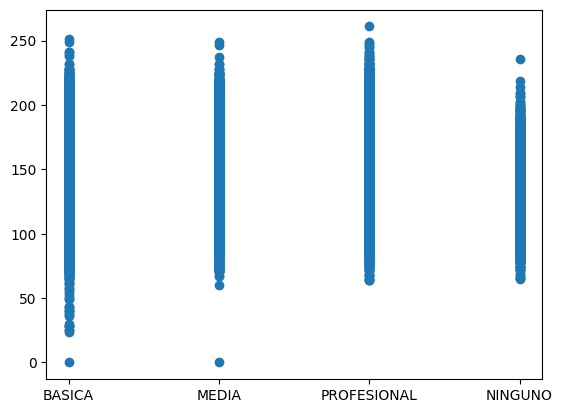

In [1018]:
correlaciones = calcular_correlacion_dummies(df, 'FAMI_EDUCACIONMADRE', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['FAMI_EDUCACIONMADRE'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['FAMI_EDUCACIONMADRE'], prefix='EDUCACIONMADRE', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [1019]:
MODA = dfTest['FAMI_EDUCACIONMADRE'].value_counts().idxmax()
dfTest['FAMI_EDUCACIONMADRE'] = dfTest['FAMI_EDUCACIONMADRE'].fillna(MODA)
dfTest['FAMI_EDUCACIONMADRE'] = dfTest['FAMI_EDUCACIONMADRE'].replace({
    'Educación profesional completa': 'PROFESIONAL',
    'Educación profesional incompleta': 'PROFESIONAL', 
    'Postgrado': 'PROFESIONAL',
    'Técnica o tecnológica completa': 'MEDIA',
    'Técnica o tecnológica incompleta': 'MEDIA',
    'Primaria completa': 'BASICA',
    'Primaria incompleta': 'BASICA',
    'Secundaria (Bachillerato) completa': 'BASICA',
    'Secundaria (Bachillerato) incompleta': 'BASICA',
    'Ninguno': 'NINGUNO',
    'No Aplica': 'NINGUNO',
    'No sabe': 'NINGUNO'
})
dummies = pd.get_dummies(dfTest['FAMI_EDUCACIONMADRE'], prefix='EDUCACIONMADRE', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## FAMI_ESTRATOVIVIENDA

In [1020]:
MODA = df['FAMI_ESTRATOVIVIENDA'].value_counts().idxmax()
df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].fillna(MODA)

In [1021]:
df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].replace({
    'Estrato 1': 1,
    'Estrato 2': 2,
    'Estrato 3': 3,
    'Estrato 4': 4,
    'Estrato 5': 5,
    'Estrato 6': 6,
    'Sin Estrato': 0
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_11252\4120554201.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].replace({


0   -0.037404
1   -0.160728
2   -0.072688
3    0.076760
4    0.143866
5    0.112342
6    0.087452
dtype: float64


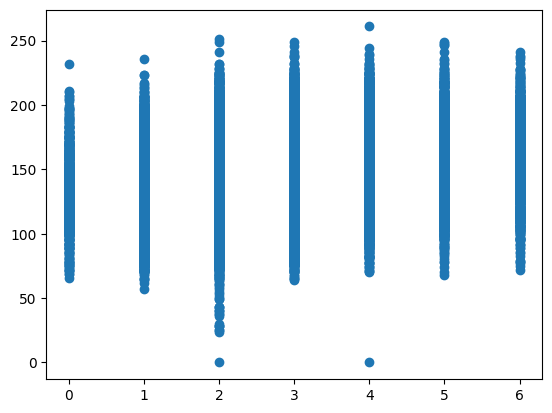

In [1022]:
correlaciones = calcular_correlacion_dummies(df, 'FAMI_ESTRATOVIVIENDA', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['FAMI_ESTRATOVIVIENDA'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['FAMI_ESTRATOVIVIENDA'], prefix='ESTRATO', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [1023]:
MODA = dfTest['FAMI_ESTRATOVIVIENDA'].value_counts().idxmax()
dfTest['FAMI_ESTRATOVIVIENDA'] = dfTest['FAMI_ESTRATOVIVIENDA'].fillna(MODA)
dfTest['FAMI_ESTRATOVIVIENDA'] = dfTest['FAMI_ESTRATOVIVIENDA'].replace({
    'Estrato 1': 1,
    'Estrato 2': 2,
    'Estrato 3': 3,
    'Estrato 4': 4,
    'Estrato 5': 5,
    'Estrato 6': 6,
    'Sin Estrato': 0
})
dummies = pd.get_dummies(dfTest['FAMI_ESTRATOVIVIENDA'], prefix='ESTRATO', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

C:\Users\Migue\AppData\Local\Temp\ipykernel_11252\4071353882.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfTest['FAMI_ESTRATOVIVIENDA'] = dfTest['FAMI_ESTRATOVIVIENDA'].replace({


___

## FAMI_TIENEINTERNET

In [1024]:
MODA = df['FAMI_TIENEINTERNET'].value_counts().idxmax()
df['FAMI_TIENEINTERNET'] = df['FAMI_TIENEINTERNET'].fillna(MODA)

In [1025]:
df['TIENEINTERNET'] = df['FAMI_TIENEINTERNET'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_11252\3439167256.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TIENEINTERNET'] = df['FAMI_TIENEINTERNET'].replace({


               PUNT_GLOBAL  TIENEINTERNET
PUNT_GLOBAL       1.000000       0.141491
TIENEINTERNET     0.141491       1.000000


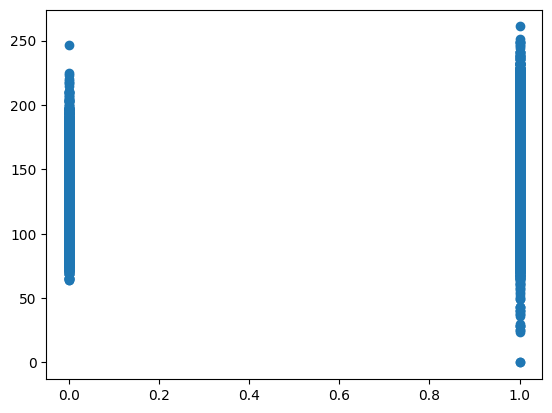

In [1026]:
print(df[['PUNT_GLOBAL', 'TIENEINTERNET']].corr())
plt.scatter(df['TIENEINTERNET'], df['PUNT_GLOBAL'])
dfFinal = pd.concat([dfFinal, df['TIENEINTERNET']], axis=1)

In [1027]:
MODA = dfTest['FAMI_TIENEINTERNET'].value_counts().idxmax()
dfTest['FAMI_TIENEINTERNET'] = dfTest['FAMI_TIENEINTERNET'].fillna(MODA)
dfTest['TIENEINTERNET'] = dfTest['FAMI_TIENEINTERNET'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_11252\2982809549.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfTest['TIENEINTERNET'] = dfTest['FAMI_TIENEINTERNET'].replace({


___

## FAMI_TIENESERVICIOTV

In [1028]:
MODA = df['FAMI_TIENESERVICIOTV'].value_counts().idxmax()
df['FAMI_TIENESERVICIOTV'] = df['FAMI_TIENESERVICIOTV'].fillna(MODA)

In [1029]:
df['TIENESERVICIOTV'] = df['FAMI_TIENESERVICIOTV'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_11252\485018897.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TIENESERVICIOTV'] = df['FAMI_TIENESERVICIOTV'].replace({


                 PUNT_GLOBAL  TIENESERVICIOTV
PUNT_GLOBAL         1.000000         0.040291
TIENESERVICIOTV     0.040291         1.000000


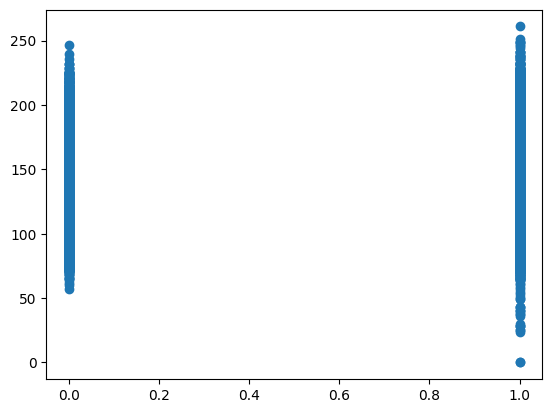

In [1030]:
print(df[['PUNT_GLOBAL', 'TIENESERVICIOTV']].corr())
plt.scatter(df['TIENESERVICIOTV'], df['PUNT_GLOBAL'])
dfFinal = pd.concat([dfFinal, df['TIENESERVICIOTV']], axis=1)

In [1031]:
MODA = dfTest['FAMI_TIENESERVICIOTV'].value_counts().idxmax()
dfTest['FAMI_TIENESERVICIOTV'] = dfTest['FAMI_TIENESERVICIOTV'].fillna(MODA)
dfTest['TIENESERVICIOTV'] = dfTest['FAMI_TIENESERVICIOTV'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_11252\3525001120.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfTest['TIENESERVICIOTV'] = dfTest['FAMI_TIENESERVICIOTV'].replace({


___

## FAMI_TIENECOMPUTADOR

In [1032]:
MODA = df['FAMI_TIENECOMPUTADOR'].value_counts().idxmax()
df['FAMI_TIENECOMPUTADOR'] = df['FAMI_TIENECOMPUTADOR'].fillna(MODA)

In [1033]:
df['TIENECOMPUTADOR'] = df['FAMI_TIENECOMPUTADOR'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_11252\4249773009.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TIENECOMPUTADOR'] = df['FAMI_TIENECOMPUTADOR'].replace({


                 PUNT_GLOBAL  TIENECOMPUTADOR
PUNT_GLOBAL         1.000000         0.147503
TIENECOMPUTADOR     0.147503         1.000000


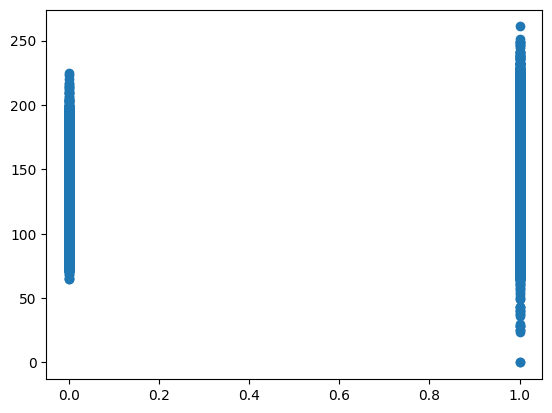

In [1034]:
print(df[['PUNT_GLOBAL', 'TIENECOMPUTADOR']].corr())
plt.scatter(df['TIENECOMPUTADOR'], df['PUNT_GLOBAL'])
dfFinal = pd.concat([dfFinal, df['TIENECOMPUTADOR']], axis=1)

In [1035]:
MODA = dfTest['FAMI_TIENECOMPUTADOR'].value_counts().idxmax()
dfTest['FAMI_TIENECOMPUTADOR'] = dfTest['FAMI_TIENECOMPUTADOR'].fillna(MODA)
dfTest['TIENECOMPUTADOR'] = dfTest['FAMI_TIENECOMPUTADOR'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_11252\4032842601.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfTest['TIENECOMPUTADOR'] = dfTest['FAMI_TIENECOMPUTADOR'].replace({


___

## FAMI_TIENECONSOLAVIDEOJUEGOS

In [1036]:
MODA = df['FAMI_TIENECONSOLAVIDEOJUEGOS'].value_counts().idxmax()
df['FAMI_TIENECONSOLAVIDEOJUEGOS'] = df['FAMI_TIENECONSOLAVIDEOJUEGOS'].fillna(MODA)

In [1037]:
df['TIENECONSOLAVIDEOJUEGOS'] = df['FAMI_TIENECONSOLAVIDEOJUEGOS'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_11252\2147797429.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TIENECONSOLAVIDEOJUEGOS'] = df['FAMI_TIENECONSOLAVIDEOJUEGOS'].replace({


                         PUNT_GLOBAL  TIENECONSOLAVIDEOJUEGOS
PUNT_GLOBAL                   1.0000                   0.1398
TIENECONSOLAVIDEOJUEGOS       0.1398                   1.0000


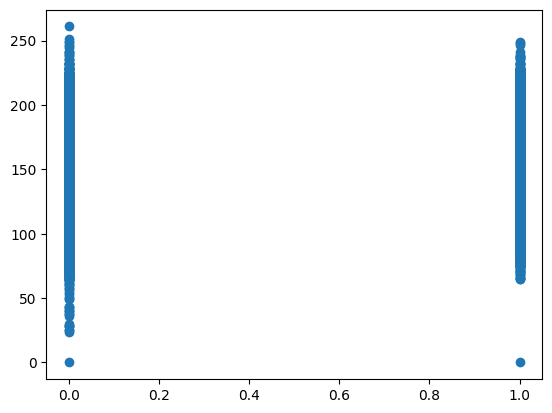

In [1038]:
print(df[['PUNT_GLOBAL', 'TIENECONSOLAVIDEOJUEGOS']].corr())
plt.scatter(df['TIENECONSOLAVIDEOJUEGOS'], df['PUNT_GLOBAL'])
dfFinal = pd.concat([dfFinal, df['TIENECONSOLAVIDEOJUEGOS']], axis=1)

In [1039]:
MODA = dfTest['FAMI_TIENECONSOLAVIDEOJUEGOS'].value_counts().idxmax()
dfTest['FAMI_TIENECONSOLAVIDEOJUEGOS'] = dfTest['FAMI_TIENECONSOLAVIDEOJUEGOS'].fillna(MODA)
dfTest['TIENECONSOLAVIDEOJUEGOS'] = dfTest['FAMI_TIENECONSOLAVIDEOJUEGOS'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_11252\4255556452.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfTest['TIENECONSOLAVIDEOJUEGOS'] = dfTest['FAMI_TIENECONSOLAVIDEOJUEGOS'].replace({


___

## ESTU_HORASSEMANATRABAJA

In [1040]:
MODA = df['ESTU_HORASSEMANATRABAJA'].value_counts().idxmax()
df['ESTU_HORASSEMANATRABAJA'] = df['ESTU_HORASSEMANATRABAJA'].fillna(MODA)

0                      0.124040
Entre 11 y 20 horas   -0.017382
Entre 21 y 30 horas   -0.024759
Menos de 10 horas     -0.012972
Más de 30 horas       -0.047126
dtype: float64


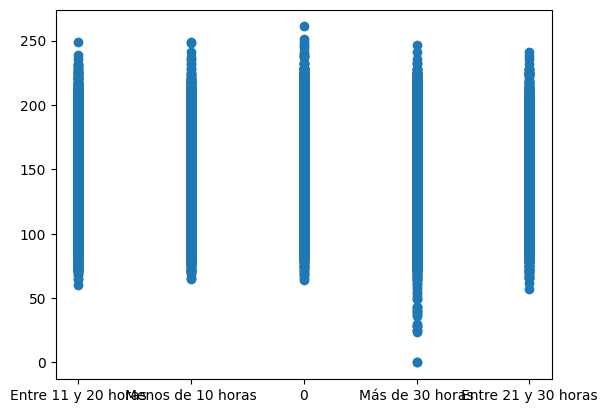

In [1041]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_HORASSEMANATRABAJA', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_HORASSEMANATRABAJA'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['ESTU_HORASSEMANATRABAJA'], prefix='HORASSEMANATRABAJA', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [1042]:
MODA = dfTest['ESTU_HORASSEMANATRABAJA'].value_counts().idxmax()
dfTest['ESTU_HORASSEMANATRABAJA'] = dfTest['ESTU_HORASSEMANATRABAJA'].fillna(MODA)
dummies = pd.get_dummies(dfTest['ESTU_HORASSEMANATRABAJA'], prefix='HORASSEMANATRABAJA', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## GRUPOREFERENCIA

In [1043]:
MODA = df['GRUPOREFERENCIA'].value_counts().idxmax()
df['GRUPOREFERENCIA'] = df['GRUPOREFERENCIA'].fillna(MODA)

In [1044]:
grupo_referencia_map = {
    # Grupo SALUD
    'SALUD': 'SALUD',
    'PSICOLOGÍA': 'SALUD',
    'MEDICINA': 'SALUD',
    'ENFERMERÍA': 'SALUD',
    
    # Grupo INGENIERÍAS Y AFINES
    'INGENIERÍA': 'INGENIERÍAS Y AFINES',
    'ARQUITECTURA Y URBANISMO ': 'INGENIERÍAS Y AFINES',
    'CIENCIAS NATURALES Y EXACTAS': 'INGENIERÍAS Y AFINES',

    # Grupo CIENCIAS SOCIALES Y HUMANIDADES
    'CIENCIAS SOCIALES': 'CIENCIAS SOCIALES Y HUMANIDADES',
    'HUMANIDADES': 'CIENCIAS SOCIALES Y HUMANIDADES',
    'BELLAS ARTES Y DISEÑO': 'CIENCIAS SOCIALES Y HUMANIDADES',
    'COMUNICACIÓN, PERIODISMO Y PUBLICIDAD': 'CIENCIAS SOCIALES Y HUMANIDADES',
    'RECREACIÓN Y DEPORTES': 'CIENCIAS SOCIALES Y HUMANIDADES',

    # Grupo ADMINISTRACIÓN Y AFINES
    'ADMINISTRACIÓN Y AFINES': 'ADMINISTRACIÓN Y AFINES',
    'CONTADURÍA Y AFINES': 'ADMINISTRACIÓN Y AFINES',
    'ECONOMÍA': 'ADMINISTRACIÓN Y AFINES',
    'ECONOMÍA, ADMINISTRACIÓN, CONTADURÍA Y AFINES - UNIVERSITARIA': 'ADMINISTRACIÓN Y AFINES',

    # Grupo DERECHO
    'DERECHO': 'DERECHO',
    
    # Grupo CIENCIAS AGROPECUARIAS
    'CIENCIAS AGROPECUARIAS ': 'CIENCIAS AGROPECUARIAS',

    # Grupo EDUCACIÓN
    'EDUCACIÓN': 'EDUCACIÓN',

    # Grupo CIENCIAS MILITARES Y NAVALES
    'CIENCIAS MILITARES Y NAVALES': 'CIENCIAS MILITARES Y NAVALES',
    
    # Grupo REFERENCIA NACIONAL
    'GRUPO REFERENCIA NACIONAL UNIVERSITARIO': 'GRUPO REFERENCIA NACIONAL',
    'GRUPO REFERENCIA NACIONAL': 'GRUPO REFERENCIA NACIONAL'
}

df['GRUPOREFERENCIA'] = df['GRUPOREFERENCIA'].replace(grupo_referencia_map)


ADMINISTRACIÓN Y AFINES           -0.125202
CIENCIAS AGROPECUARIAS            -0.005863
CIENCIAS MILITARES Y NAVALES      -0.000831
CIENCIAS SOCIALES Y HUMANIDADES    0.064522
DERECHO                            0.051178
EDUCACIÓN                         -0.047192
GRUPO REFERENCIA NACIONAL         -0.073400
INGENIERÍAS Y AFINES               0.145582
SALUD                             -0.020864
dtype: float64


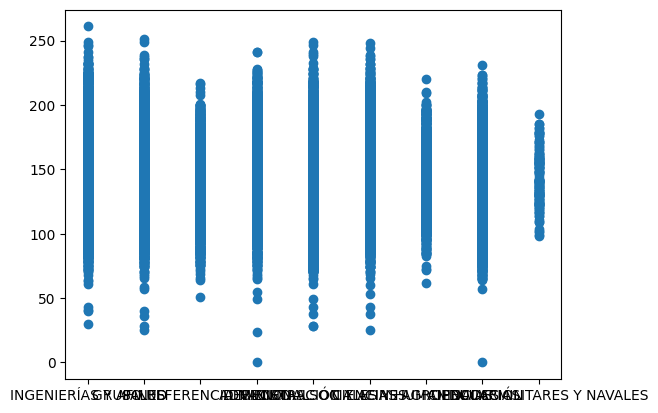

In [1045]:
correlaciones = calcular_correlacion_dummies(df, 'GRUPOREFERENCIA', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['GRUPOREFERENCIA'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['GRUPOREFERENCIA'], prefix='GRUPOREFERENCIA', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [1046]:
MODA = dfTest['GRUPOREFERENCIA'].value_counts().idxmax()
dfTest['GRUPOREFERENCIA'] = dfTest['GRUPOREFERENCIA'].fillna(MODA)
dfTest['GRUPOREFERENCIA'] = dfTest['GRUPOREFERENCIA'].replace(grupo_referencia_map)
dummies = pd.get_dummies(dfTest['GRUPOREFERENCIA'], prefix='GRUPOREFERENCIA', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_PRGM_DEPARTAMENTO

In [1047]:
df['REGION_ESTUDIO'] = df['ESTU_PRGM_DEPARTAMENTO'].apply(asignar_region)

Amazonía    -0.025598
Andina       0.095681
Caribe      -0.078658
Orinoquía   -0.019583
Otro        -0.014252
Pacífico    -0.030356
dtype: float64


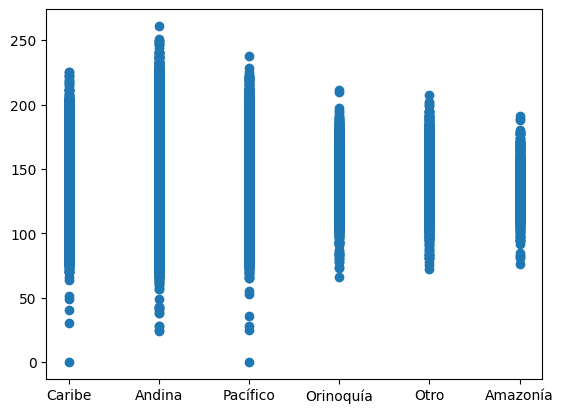

In [1048]:
correlaciones = calcular_correlacion_dummies(df, 'REGION_ESTUDIO', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['REGION_ESTUDIO'], df['PUNT_GLOBAL'])

dummies = pd.get_dummies(df['REGION_ESTUDIO'], prefix='REGION_ESTUDIO', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [1049]:
dfTest['REGION_ESTUDIO'] = dfTest['ESTU_PRGM_DEPARTAMENTO'].apply(asignar_region)
dummies = pd.get_dummies(dfTest['REGION_ESTUDIO'], prefix='REGION_ESTUDIO', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_METODO_PRGM

DISTANCIA          -0.187069
DISTANCIA VITUAL   -0.107896
PRESENCIAL          0.226862
dtype: float64


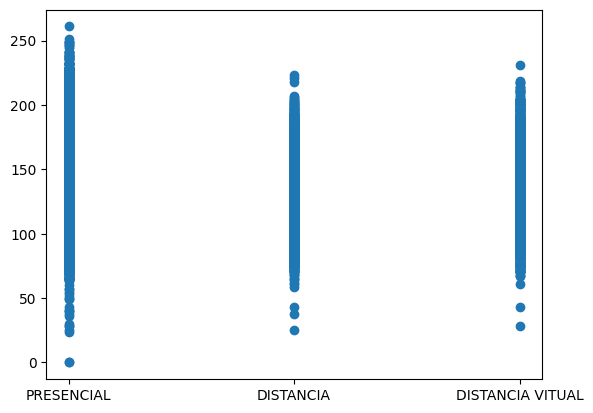

In [1050]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_METODO_PRGM', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_METODO_PRGM'], df['PUNT_GLOBAL'])

dummies = pd.get_dummies(df['ESTU_METODO_PRGM'], prefix='METODO_ESTUDIO', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [1051]:
dummies = pd.get_dummies(dfTest['ESTU_METODO_PRGM'], prefix='METODO_ESTUDIO', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## INST_CARACTER_ACADEMICO

INSTITUCIÓN TECNOLÓGICA     -0.115303
INSTITUCIÓN UNIVERSITARIA   -0.223687
TÉCNICA PROFESIONAL         -0.069109
UNIVERSIDAD                  0.292784
dtype: float64


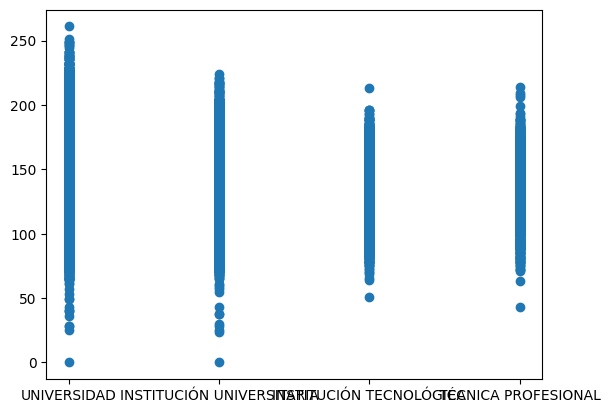

In [1052]:
correlaciones = calcular_correlacion_dummies(df, 'INST_CARACTER_ACADEMICO', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['INST_CARACTER_ACADEMICO'], df['PUNT_GLOBAL'])

dummies = pd.get_dummies(df['INST_CARACTER_ACADEMICO'], prefix='INST_CARACTER', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [1053]:
dummies = pd.get_dummies(dfTest['INST_CARACTER_ACADEMICO'], prefix='INST_CARACTER', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

# Regresión

In [1054]:
X = dfFinal.drop(columns=['PUNT_GLOBAL'])  # Variables predictoras
y = dfFinal['PUNT_GLOBAL']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)


r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R²: {r2}")
print(f"MAPE: {mape}")
print(f"MSE: {mse}")


R²: 0.26073256495882857
MAPE: 20832825139057.484
MSE: 407.5020128963261


In [1055]:
y_pred = modelo.predict(dfTest[list(X.columns)])

resultado = pd.DataFrame({
    'id': dfTest['ESTU_CONSECUTIVO'],
    'GLOBAL_SCORE': y_pred
})

resultado.to_csv('submissions/regresion.csv', index=False)


___

# KNN

In [1056]:
X = dfFinal.drop(columns=['PUNT_GLOBAL'])
y = dfFinal['PUNT_GLOBAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

vecinos_a_probar = [5, 10, 20, 30, 40, 50, 60]
resultados_mse = {}

for k in vecinos_a_probar:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    y_pred = knn.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    
    resultados_mse[k] = mse
    print(f"MSE para {k} vecinos: {mse}")

mejor_k = min(resultados_mse, key=resultados_mse.get)
print(f"El mejor número de vecinos es {mejor_k} con un MSE de {resultados_mse[mejor_k]}")


MSE para 5 vecinos: 469.8528870142691
MSE para 10 vecinos: 433.686015734841
MSE para 20 vecinos: 418.300054144605
MSE para 30 vecinos: 413.8755004802882
MSE para 40 vecinos: 412.36831734796135
MSE para 50 vecinos: 411.66935519459156
MSE para 60 vecinos: 411.03527804368133
El mejor número de vecinos es 60 con un MSE de 411.03527804368133


In [1057]:
mejor_k = 60

X_test_real = dfTest[list(X.columns)]
X_test_real_scaled = scaler.transform(X_test_real)

knn = KNeighborsRegressor(n_neighbors=mejor_k)

knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_real_scaled)

resultado = pd.DataFrame({
    'id': dfTest['ESTU_CONSECUTIVO'],
    'GLOBAL_SCORE': y_pred
})

resultado.to_csv('submissions/knn_submission.csv', index=False)


___

# GBM

In [1058]:
X = dfFinal.drop(columns=['PUNT_GLOBAL'])
y = dfFinal['PUNT_GLOBAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

gbm.fit(X_train_scaled, y_train)

y_pred_train = gbm.predict(X_train_scaled)
y_pred_test = gbm.predict(X_test_scaled)

mse_train = mean_squared_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"MSE en entrenamiento: {mse_train}")
print(f"MAPE en entrenamiento: {mape_train}")
print(f"MSE en prueba: {mse_test}")
print(f"MAPE en prueba: {mape_test}")

MSE en entrenamiento: 390.59556134711744
MAPE en entrenamiento: 7874948689406.298
MSE en prueba: 395.66640047319777
MAPE en prueba: 20175716782170.973


In [1059]:
X_test_real = dfTest[list(X.columns)]
X_test_real_scaled = scaler.transform(X_test_real)

y_pred = gbm.predict(X_test_real_scaled)

resultado = pd.DataFrame({
    'id': dfTest['ESTU_CONSECUTIVO'],
    'GLOBAL_SCORE': y_pred
})

resultado.to_csv('submissions/gbm_submission.csv', index=False)